In [9]:
import serial
import time
import math
import pyvisa
import sys
import numpy as np
from decimal import Decimal
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import clear_output
from datetime import datetime

import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import threading

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [10]:
###############################
##Specify SA GPIB address######
visa_address = "GPIB0::0::0::INSTR"
###############################

In [11]:
#HP 8560A command set
#IDN
GET_ID = "ID?"
#Center frequency
SET_CENTER_FREQ = "CF "
GET_CENTER_FREQ = "CF?"
#Span
SET_SPAN = "SP "
GET_SPAN = "SP?"
#Resolution BW
SET_RBW = "RB "
GET_RBW = "RB?"
#Amplitude reference level
SET_RL = "RL "
GET_RL = "RL?"
#Sweep time
SET_SWEEP_TIME = "ST "
GET_SWEEP_TIME = "ST?"

In [12]:
###############################
##Spectrum capture parameters##
spectrumCenter = "2440000000"
spectrumSpan = "100000000"
spectrumRBW = "1000000"
spectrumReferenceLevel = "10"
###############################

In [13]:
class SpectrumAnalyzer:
    def __init__(self, visa_address):
        self.visa_address = visa_address
        self._connect()
        
    def _connect(self):
        rm = pyvisa.ResourceManager()
        self.visa_resource = rm.open_resource(self.visa_address)
        self.visa_resource.write(GET_ID)
        self.id = self.visa_resource.read().rstrip()
        print(f"Connected to {self.id}")
        
        #Get parameters
        self.get_frequency_center()
        self.get_span()
        self.get_rbw()
        self.get_reference_level()
        self.get_sweep_time()
        
    def close(self):
        if self.visa_resource:
            self.visa_resource.close()
            print("Connection closed.")
            
    def get_trace(self):
        #Set timeout according to sweep time
        self.visa_resource.write(GET_SWEEP_TIME)
        sweep = self.visa_resource.read().replace("\n", "")
        self.visa_resource.timeout = math.ceil(float(sweep)+10)
        
        self.visa_resource.write("TRA?")
        trace_data = self.visa_resource.read()
        trace_data = trace_data[0:len(trace_data)-1]
        data = trace_data.split(",")
        data = [float(value) for value in data]
        return data
    
    #Center frequency
    def get_frequency_center(self):
        self.visa_resource.write(GET_CENTER_FREQ)
        self.center_frequency = float(self.visa_resource.read().rstrip())
        return self.center_frequency
        
    def set_frequency_center(self, center):
        if 0 < center <= 3e9:  # Example: 3 GHz limit
            self.visa_resource.write(f"{SET_CENTER_FREQ}{center}")
            self.center_frequency = center
        else:
            raise ValueError("Center frequency must be between 0 and 3 GHz.")

    #Span
    def get_span(self):
        self.visa_resource.write(GET_SPAN)
        self.span = float(self.visa_resource.read().strip())
        return self.span

    def set_span(self, span):
        if span > 0:
            self.visa_resource.write(f"{SET_SPAN}{span}")
            self.span = span
        else:
            raise ValueError("Span must be positive.")
    
    # Resolution Bandwidth (RBW)
    def get_rbw(self):
        self.visa_resource.write(GET_RBW)
        self.rbw = float(self.visa_resource.read().strip())
        return self.rbw

    def set_rbw(self, rbw):
        if rbw > 0:
            self.visa_resource.write(f"{SET_RBW}{rbw}")
            self.rbw = rbw
        else:
            raise ValueError("Resolution bandwidth must be positive.")

    # Reference Level
    def get_reference_level(self):
        self.visa_resource.write(GET_RL)
        self.reference_level = float(self.visa_resource.read().strip())
        return self.reference_level

    def set_reference_level(self, level):
        self.visa_resource.write(f"{SET_RL}{level}")
        self.reference_level = level

    # Sweep Time
    def get_sweep_time(self):
        self.visa_resource.write(GET_SWEEP_TIME)
        self.sweep_time = float(self.visa_resource.read().strip())
        return self.sweep_time

    def set_sweep_time(self, time):
        if time > 0:
            self.visa_resource.write(f"{SET_SWEEP_TIME}{time}")
            self.sweep_time = time
        else:
            raise ValueError("Sweep time must be positive.")

instrument.write("CF?")
spectrumCenter = instrument.read().rstrip()

instrument.write("SP?")
spectrumSpan = instrument.read().rstrip()

instrument.write("RB?")
spectrumRBW = instrument.read().rstrip()

instrument.write("RL?")
spectrumReferenceLevel = instrument.read().rstrip()

#Set timeout according to sweep time
instrument.write(GET_SWEEP_TIME)
sweep = instrument.read().replace("\n", "")
instrument.timeout = math.ceil(float(sweep)+10)


Connected to HP8560A


Exception in thread Thread-5:
Traceback (most recent call last):
  File "C:\Users\Sylvain-fixe\anaconda3\envs\Python_Conf\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "C:\Users\Sylvain-fixe\anaconda3\envs\Python_Conf\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Sylvain-fixe\AppData\Local\Temp\ipykernel_18748\2672555235.py", line 11, in continuous_measurement
  File "C:\Users\Sylvain-fixe\AppData\Local\Temp\ipykernel_18748\2946987378.py", line 32, in get_trace
  File "C:\Users\Sylvain-fixe\anaconda3\envs\Python_Conf\lib\site-packages\pyvisa\resources\messagebased.py", line 486, in read
    message = self._read_raw().decode(enco)
  File "C:\Users\Sylvain-fixe\anaconda3\envs\Python_Conf\lib\site-packages\pyvisa\resources\messagebased.py", line 442, in _read_raw
    chunk, status = self.visalib.read(self.session, size)
  File "C:\Users\Sylvain-fixe\anaconda3\envs\Python_Conf\lib\site-packages\pyvisa\ctwrapper\f

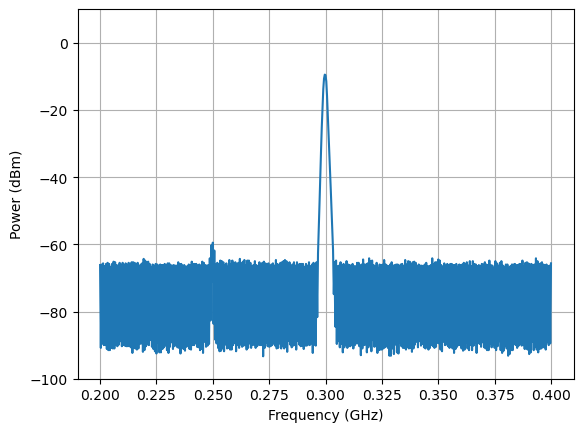

In [14]:
# Variables globales
running = True  # Pour contrôler la boucle de mesure

spectrum = SpectrumAnalyzer(visa_address)

# Fonction pour effectuer la mesure en continu
def continuous_measurement():
    global running
    while running:
        #Get measure
        data = spectrum.get_trace()

        # Mettre à jour les données sur le graphique
        ax.cla()  # Effacer le graphique précédent
        ax.plot(df1.index, data)
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('Power (dBm)')
        ax.set_ylim(-100, 10)
        ax.grid(True)
        canvas.draw()  # Rafraîchir l'affichage
        fig.canvas.draw()
        fig.canvas.flush_events()

        time.sleep(spectrum.sweep_time)  # Pause entre les mesures

# Fonction pour arrêter la mesure
def stop_measurement():
    global running
    running = False
    root.destroy()  # Fermer la fenêtre Tkinter

# Fonction pour mettre à jour les paramètres
def update_parameter(param_name, entry_widget):
    try:
        value = float(entry_widget.get())
        if param_name == "center_frequency":
            spectrum.set_frequency_center(value)
        elif param_name == "span":
            spectrum.set_span(value)
        elif param_name == "rbw":
            spectrum.set_rbw(value)
        elif param_name == "reference_level":
            spectrum.set_reference_level(value)
        elif param_name == "sweep_time":
            spectrum.set_sweep_time(value)
            spectrum.get_rbw()
    except ValueError as e:
        print(f"Invalid value for {param_name}: {e}")

# Configuration des fréquences et du graphique
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

df = pd.DataFrame(columns=range(2), index=range(601))
frequencies = range(
    int(spectrum.center_frequency) - int(spectrum.span) // 2, 
    int(spectrum.center_frequency) + int(float(spectrum.span)) // 2, 
    int(float(spectrum.span)) // 600
)
df[0] = [freq / 1e9 for freq in frequencies]
df = df.astype(float)
df1 = df.set_index(0)

# Création de l'interface graphique
root = tk.Tk()
root.title("Spectrum analyzer : " + spectrum.id)

# Intégration de la figure matplotlib dans Tkinter
canvas = FigureCanvasTkAgg(fig, master=root)
canvas_widget = canvas.get_tk_widget()
canvas_widget.pack(fill=tk.BOTH, expand=True)

# Bouton pour arrêter la mesure
stop_button = ttk.Button(root, text="Close", command=stop_measurement)
stop_button.pack()

# Création des text boxes pour les paramètres
params = {
    "Center Frequency (Hz)": ("center_frequency", spectrum.get_frequency_center),
    "Span (Hz)": ("span", spectrum.get_span),
    "RBW (Hz)": ("rbw", spectrum.get_rbw),
    "Reference Level (dBm)": ("reference_level", spectrum.get_reference_level),
    "Sweep Time (s)": ("sweep_time", spectrum.get_sweep_time)
}

for label_text, (param_name, getter) in params.items():
    frame = ttk.Frame(root)
    frame.pack(fill=tk.X, padx=5, pady=5)

    label = ttk.Label(frame, text=label_text)
    label.pack(side=tk.LEFT)

    entry = ttk.Entry(frame)
    entry.pack(side=tk.LEFT, fill=tk.X, expand=True)
    entry.insert(0, str(getter()))

    update_button = ttk.Button(frame, text="Update", command=lambda p=param_name, e=entry: update_parameter(p, e))
    update_button.pack(side=tk.RIGHT)

# Lancer la mesure en continu dans un thread séparé
thread = threading.Thread(target=continuous_measurement)
thread.start()

# Lancer la boucle principale Tkinter
root.mainloop()

# S'assurer que le thread s'arrête correctement
running = False
thread.join()

In [15]:
spectrum.close()

Connection closed.


In [16]:
frequencies = range(
    int(spectrum.center_frequency) - int(spectrum.span) // 2, 
    int(spectrum.center_frequency) + int(float(spectrum.span)) // 2, 
    int(float(spectrum.span)) // 600
)
print(frequencies)

range(200000000, 400000000, 333333)
